<div>
    <div style="text-align: right;"><span style="font-size: 24px;"><strong>Stephanie Dragoi, Steven Xu</strong></span></div> <br>
    <div style="text-align: right;"><span style="font-size: 24px;"><strong>Due 20231130 THU </strong></span></div> <br>
</div>


<div style="text-align: center;">

# Project 3: Logistic Regression Classifier

</div>

Questions for Mr. Hansen (temporary cell to delete at the end)
* Can we do research on loans and loan profitability in banking?
* Type II Error more important than Type I?

In [67]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
 accuracy_score,
 recall_score,
 precision_score,
 f1_score,
 confusion_matrix,
)

# Step 1: Create the dataframe

In [68]:
df = pd.read_csv("loan_database.csv")
df

,loan_type,loan_amount_index,previous_defaults,previous_nondefaults,previous_loan_count,cars_in_household,other_vehicles_owned,adults_in_household,children_in_household,market_segment_code,issues_needing_resolution,hmc,application_year,application_month,application_in_first_half_of_month,loan_origination,repeat_customer,mystery_field,loan_default
0,auto,134,0,0,0,1,3,3,0,ms498,0,0,2022,2,0,website,0,32,0
1,auto,118,0,0,0,0,1,2,1,ms818,2,0,2022,2,0,website,0,15,0
2,other,86,0,0,0,0,3,1,0,ms818,1,0,2021,3,1,website,0,121,0
3,auto,131,0,0,0,2,1,2,1,ms818,1,0,2021,12,1,website,0,171,1
4,auto,145,0,0,0,2,4,3,0,ms818,0,0,2022,7,0,website,0,209,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42197,auto,88,0,0,0,4,5,2,0,ms818,2,0,2021,4,0,website,0,80,0
42198,auto,160,0,0,0,0,3,2,1,ms818,2,0,2022,6,1,website,0,57,0
42199,auto,94,0,0,0,1,4,2,0,ms818,1,0,2021,10,1,website,0,28,0
42200,auto,184,0,0,0,1,2,3,0,ms604,1,0,2021,1,0,website,0,47,0


# Step 2: Understand the context

Our team is made up of data scentists for the consumer loan division of HansenBank. The objective of this project is to build a predictive logistic regression model that is useful for classifying loans as "not default" or "default". We also hope to accomplish four subtasks in support of this objective:
* To analyze the data provided
* To find which factors have a good ability to predict loan default
* To build a predictive model that can predict which loans are likely to go into default
* To suggest profitable policies for determining loan approval criteria.

We wish to predict whether loan applications are likely to result in performing or nonperforming loans in order to maximize profitability. Approving performing loans will allow HansenBank to make a profit, since the customer will make payments on time and pay an interest rate that is higher than the rate the bank itself has to pay to acquire the money for the loan. Avoiding nonperforming loans will prevent the bank from losing money. Customers who don't make payments on time or default on the loan altogether will force the bank to use time and money to pressure the customer and to recover collateral.

Given the null hypothesis of "situation normal/performing loan" in the context of this project, a Type I error occurs if the bank incorrectly rejects the null hypothesis even though the loan would have become performing. A Type II error occurs if the bank fails to reject the null hypothesis and approves the loan even though the loan will ultimately become nonperforming. We conclude that though Type I and Type II error are similar in the net loss they may incur, Type II errors are marginally worse. Type I errors would result in a loss of money due to the cost of defending against a lawsuit, which certainly would not occur in all cases of such errors. We do not consider failure to earn money that could have hypothetically been earned in the absence of such an error as a loss. Type II errors, however, always carry with them the cost of losing the loan and recovering collateral. Both errors may also result in a loss of a customer, whether it's due to the customer not wanting to do business with the bank that rejected their loan or wanting to avoid the bank that they failed to fulfill loan payments to.

Based on our decision that both types of errors are equally severe, we will most likely emphasize accuracy and recall as performance metrics, but will also consider the F1 statistic. Accuracy will measure the overall correctness of the model, recall will measure the model's performance on predicting the positive class, and F1 will recognize the tradeoff between recall and precision, or of avoiding Type II or Type I errors.

We have just described the context, objectives, significance, and rough roadmap for this project.

# Step 3: Data dictionary

* <b>loan_type</b>: auto, residential, or other
* <b>loan_amount_index</b>: 100 = national median for loan type, other quantities prorated
accordingly
* <b>previous_defaults</b>: number of times this customer has previously defaulted
* <b>previous_nondefaults</b>: number of times this customer has previously held a performing
loan (possibly still in progress)
* <b>previous_loan_count</b>: number of previous loans issued to this customer
* <b>cars_in_household</b>: number of passenger vehicles in customer's household
* <b>other_vehicles_owned</b>: number of other vehicles (boats, motorcycles, etc.) titled to the
customer
* <b>adults_in_household</b>: number of adults age 18+ in customer's household
* <b>children_in_household</b>: number of children under age 18 in customer's household
* <b>market_segment_code</b>: proprietary code for customer's market segment
* <b>issues_needing_resolution</b>: number of paperwork issues requiring special attention on
the application
* <b>hmc</b>: 1 = high maintenance customer, 0 = normal customer with no special handling needed
* <b>application_year</b>: YYYY format
* <b>application_month</b>: 1 (January) through 12 (December)
* <b>application_in_first_half_of_month</b>: 1 = application filed on day 1-15 of month, 0 =
filed any other day of month
* <b>loan_origination</b>: website, bank branch, or other
* <b>repeat_customer</b>: 1 = customer has previously been a loan customer, 0 = no previous loan
* <b>mystery_field</b>: no information
* <b>loan_default</b>: 1 = this loan ended in default, 0 = performing loan (either paid off or
in progress)

We have just created a data dictionary to allow anyone who reads this notebook to understand the meaning of each field.

# Step 4: Useful Python functions

In [69]:
# Custom code written 20210625 FRI by E. M. Hansen
# This code is a modified and simplified version of the
# histogram_boxplot custom function written by someone else.

def boxpl_and_hist(data_series): # Display a boxplot above a histogram.
# (NOTE: this code is a modified
# version of the histogram_boxplot
# custom function written by someone
# else.)
 scratch_vbl, (box1, hist1) = plt.subplots(nrows=2, # Set up combined plot with 2 rows.
 figsize=(16,8),
sharex=True, # Both plots should use same x-axis.
gridspec_kw = {"height_ratios": (.1, .9)})
 # Note: scratch_vbl must be present for code to work. Not sure
# what its purpose is, since the variable is never needed or
# used again.
 sns.boxplot(x=data_series, ax=box1, showmeans=True, color='cyan') # triangle for mean
 sns.histplot(x=data_series, ax=hist1, kde=False, color='cyan') # histplot, not distplot
 hist1.axvline(np.mean(data_series), color='green', linestyle='--') # mean (dotted)
 hist1.axvline(np.median(data_series), color='magenta', linestyle='-') # median (solid)
 plt.show() # Display both plots.

In [70]:
# Function to return a dataframe showing the VIF for each explanatory variable:
# Note that the explanatory variables are in a dataframe called Xdataframe.

def calculate_vif(Xdataframe):
 temp_df = pd.DataFrame()
 temp_df["column name"] = Xdataframe.columns
 temp_df["VIF"] = [variance_inflation_factor(Xdataframe.values, k)
 for k in range(len(Xdataframe.columns))]
 return temp_df

In [71]:
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
 y_pred = model.predict(predictors) > threshold
 cm = confusion_matrix(target, y_pred)
 labels = np.asarray(
 [
 ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
 for item in cm.flatten()
 ]
 ).reshape(2, 2)
 plt.figure(figsize=(6, 4))
 sns.heatmap(cm, annot=labels, fmt="")
 plt.ylabel("True value of target")
 plt.xlabel("Predicted value of target")

In [72]:
def model_performance_classification_statsmodels(model, predictors, target, threshold=0.5):
 # checking which probabilities are greater than threshold
 pred_temp = model.predict(predictors) > threshold
 # rounding off the above values to get classes
 pred = np.round(pred_temp)
 acc = accuracy_score(target, pred) # compute Accuracy
 recall = recall_score(target, pred) # compute Recall
 precision = precision_score(target, pred) # compute Precision
 f1 = f1_score(target, pred) # compute F1
 # creating a dataframe of metrics
 df_perf = pd.DataFrame(
 {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,}, index=[0])
 return df_perf

In [73]:
def bargraph_with_labels(data, feature, perc=False, n=None): # author unknown
 # data = placeholder for dataframe (df)
# feature = column to graph
# perc = display %s instead of counts
# n = number of category levels to show
 total = len(data[feature])
 count = data[feature].nunique()
 if n is None:
     plt.figure(figsize=(count + 2, 6))
 else:
     plt.figure(figsize=(n + 2, 6))
 plt.xticks(rotation=90, fontsize=12)
 ax = sns.countplot(
 data=data,
 x=feature,
 palette="Paired",
 order=data[feature].value_counts().index[:n].sort_values(),
 )
 for p in ax.patches:
     if perc == True:
         label = "{:.1f}%".format(
         100 * p.get_height() / total
         )
     else:
         label = p.get_height()
     x = p.get_x() + p.get_width() / 2 # width of plot
     y = p.get_height() # height of plot
     ax.annotate(
     label,
     (x, y),
     ha="center",
     va="center",
     size=12,
     xytext=(0, 5),
     textcoords="offset points",
     )
 plt.show()

In [74]:
def plot_categorical_vs_target(data, feature, target_vbl_name):
 x,y = feature, target_vbl_name
 for feature in [data]:
        (feature
 .groupby(x)[y]
 .value_counts(normalize=True)
 .mul(100)
 .rename('percent')
 .reset_index()
 .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
 plt.show()


In [75]:
def boxplots_vs_target(data, feature, target_vbl_name):
 figsize=(12, 10)
 sns.boxplot(data=data, x=target_vbl_name, y=feature, palette="gist_rainbow")
 plt.show()

We have just defined some useful Python functions.

# Step 5: Drop duplicate rows

In [76]:
df[df.duplicated()].count()

loan_type                             1947
loan_amount_index                     1947
previous_defaults                     1947
previous_nondefaults                  1947
previous_loan_count                   1947
cars_in_household                     1947
other_vehicles_owned                  1947
adults_in_household                   1947
children_in_household                 1947
market_segment_code                   1947
issues_needing_resolution             1947
hmc                                   1947
application_year                      1947
application_month                     1947
application_in_first_half_of_month    1947
loan_origination                      1947
repeat_customer                       1947
mystery_field                         1947
loan_default                          1947
dtype: int64

In [77]:
df.drop_duplicates(inplace=True)
df.shape[0]

40255

We have just dropped any duplicate rows. Since 1,947 subtracted from the original number of rows, 42,202, equals 40,255, the counts are correct.

# Step 6: Look for missing values

In [78]:
df.isnull().sum()

loan_type                             0
loan_amount_index                     0
previous_defaults                     0
previous_nondefaults                  0
previous_loan_count                   0
cars_in_household                     0
other_vehicles_owned                  0
adults_in_household                   0
children_in_household                 0
market_segment_code                   0
issues_needing_resolution             0
hmc                                   0
application_year                      0
application_month                     0
application_in_first_half_of_month    0
loan_origination                      0
repeat_customer                       0
mystery_field                         0
loan_default                          0
dtype: int64

We have checked for any missing or null values. Since the sums are all 0, there are no missing values.

# Step 7: Display summary statistics

In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount_index,40255.0,106.992001,38.746823,0.0,81.0,100.0,128.0,376.0
previous_defaults,40255.0,0.027475,0.363116,0.0,0.0,0.0,0.0,11.0
previous_nondefaults,40255.0,0.235126,2.293531,0.0,0.0,0.0,0.0,72.0
previous_loan_count,40255.0,0.262601,2.523291,0.0,0.0,0.0,0.0,78.0
cars_in_household,40255.0,0.834157,0.861774,0.0,0.0,1.0,2.0,7.0
other_vehicles_owned,40255.0,2.200944,1.395875,0.0,1.0,2.0,3.0,17.0
adults_in_household,40255.0,1.861533,0.525784,0.0,2.0,2.0,2.0,4.0
children_in_household,40255.0,0.105651,0.395912,0.0,0.0,0.0,0.0,10.0
issues_needing_resolution,40255.0,0.779332,0.856337,0.0,0.0,1.0,1.0,5.0
hmc,40255.0,0.033809,0.180741,0.0,0.0,0.0,0.0,1.0


We have displayed the summary statistics for the dataframe. There does not seem to be any suspiciously low "min" values. However, the fields with suspiciously high "max" values are
* previous_defaults with 11
* previous_nondefaults with 72
* previous_loan_count with 78
* cars_in_household with 7
* other_vehicles_owned with 17
* children_in_household with 10.

# Step 8: Display boxplot and histogram for loan_amount_index field

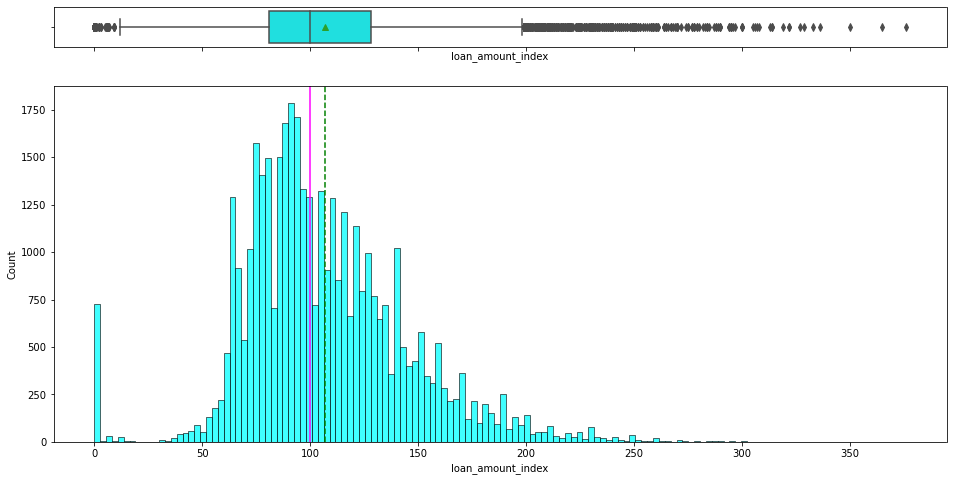

In [80]:
boxpl_and_hist(df["loan_amount_index"])

We have displayed the boxplot and histogram for the loan_amount_index_field. There is some right-skewness. There is also a good number of samples with a loan amount index of 0.

# Step 9: Drop records for which loan_amount_index is 0

In [81]:
# new df only for records where loan_amount_index = 0
filtered_df = df[df['loan_amount_index'] == 0]
result_df = pd.concat([filtered_df.head(), filtered_df.tail()])

# displaying first 5 and last 5 records
result_df

,loan_type,loan_amount_index,previous_defaults,previous_nondefaults,previous_loan_count,cars_in_household,other_vehicles_owned,adults_in_household,children_in_household,market_segment_code,issues_needing_resolution,hmc,application_year,application_month,application_in_first_half_of_month,loan_origination,repeat_customer,mystery_field,loan_default
132,auto,0,0,0,0,2,3,1,0,ms818,0,0,2020,7,0,website,0,210,0
149,other,0,0,0,0,2,1,2,0,ms818,1,0,2022,5,0,website,0,22,0
195,auto,0,0,0,0,0,2,2,0,ms818,1,0,2022,3,1,other,0,41,0
196,auto,0,3,13,16,0,2,1,0,ms296,1,0,2021,7,1,other,1,23,0
257,auto,0,0,0,0,2,0,1,0,ms818,0,0,2021,1,0,other,0,24,0
41691,auto,0,0,12,12,0,1,1,0,ms818,1,0,2022,5,0,other,1,36,0
41790,auto,0,0,0,0,0,1,2,0,ms818,1,0,2020,11,0,other,0,14,0
41858,auto,0,0,0,0,2,0,1,0,ms818,0,0,2021,3,1,other,0,15,0
41905,auto,0,0,0,0,0,1,2,0,ms498,1,0,2022,2,0,other,0,6,0
42001,auto,0,0,0,0,0,1,1,0,ms818,3,0,2021,5,0,other,0,9,0


In [82]:
df.drop(df[df['loan_amount_index'] == 0].index, inplace=True)

# display number of rows
df.shape[0]

39546

We have dropped the records in which the loan_amount_index field equals 0. The record count of 39,546 is still correct since 709 subtracted from 40,255 is equal to 39,546.

It makes sense to drop those 709 records because they are not representative of the broader distribution of the field. In the histogram, most of the field values are clustered between the values of 50 and 200. 

# Step 10: Convert categorical variables to true categories

In [83]:
df['loan_type'] = df['loan_type'].astype('category')
df['market_segment_code'] = df['market_segment_code'].astype('category')
df['loan_origination'] = df['loan_origination'].astype('category')

In [84]:
df['application_year'] = pd.Categorical(df['application_year'], ordered=True)
df['application_month'] = pd.Categorical(df['application_month'], ordered=True)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39546 entries, 0 to 42201
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   loan_type                           39546 non-null  category
 1   loan_amount_index                   39546 non-null  int64   
 2   previous_defaults                   39546 non-null  int64   
 3   previous_nondefaults                39546 non-null  int64   
 4   previous_loan_count                 39546 non-null  int64   
 5   cars_in_household                   39546 non-null  int64   
 6   other_vehicles_owned                39546 non-null  int64   
 7   adults_in_household                 39546 non-null  int64   
 8   children_in_household               39546 non-null  int64   
 9   market_segment_code                 39546 non-null  category
 10  issues_needing_resolution           39546 non-null  int64   
 11  hmc                         

We have just converted the the fields loan_type, market_segment_code, loan_origination, application_year, and application_month into categorical variables. 

We do not need to do the same thing for the hmc, application_in_first_half_if_month, repeat_customer, and loan_default variables because they are booleans. They need to be one-hot encoded and they already are, since all the values are either 1 or 0. 



# Step 11: Test for imbalance in target variable

In [86]:
print("Percentage of 1 values in target variable: ", (df['loan_default'].sum()/df['loan_default'].count())*100)
print("Percentage of 0 values in target variable: ", (1-(df['loan_default'].sum()/df['loan_default'].count()))*100)

Percentage of 1 values in target variable:  16.59586304556719
Percentage of 0 values in target variable:  83.4041369544328


The target variable is quite imbalanced, with a 0:1 split of about 83/16. This is not surprising, since one would expect the majority of customers not to default on loans, but this skewnes in the data may affect the model performance depending on the results of our EDA.

We have just examined the 0:1 split in the target variable.

# Step 12: Exploratory data analysis (EDA) for application_month

<AxesSubplot:xlabel='application_month', ylabel='count'>

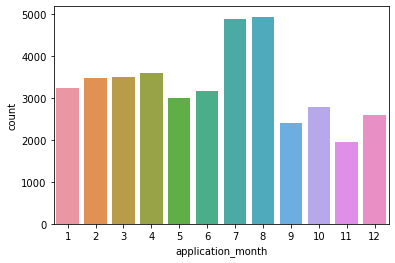

In [87]:
sns.countplot(x='application_month', data=df)

July and August seem to be the most popular months for applying for loans.

In [88]:
pd.crosstab(df['application_month'], df['application_year'], dropna=False)

application_year,2020,2021,2022
application_month,,,
1,0,1932,1312
2,0,2139,1329
3,0,1687,1825
4,0,1737,1855
5,0,916,2095
6,0,1297,1873
7,1310,1827,1737
8,1444,1951,1542
9,553,1858,0


Counting the number of applications by month does not explain which months are the most popular for applying for loans because there is no data for the first 6 months of 2020 and the last 4 months of 2022. As a result, July and August, the months that have data for all 3 years, will seem to be the most popular month based solely on this data file.

In [89]:
plot_df = pd.DataFrame([[1,0],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]])
ctab=pd.crosstab(df['application_month'], df['application_year'], dropna=False)
grandtotal = 0
for i in range (ctab.shape[0]):
 month = ctab.index[i]
 rowtotal = 0
 num_of_nonzeros = 0 # counter for number of nonzero month values in crosstab table
 for j in range (3):
     rowtotal = rowtotal + ctab.iloc[i,j]
     if ctab.iloc[i,j] > 0:
         num_of_nonzeros = num_of_nonzeros + 1
 print('Month',month,
     ': total # of records =',rowtotal,
     'for',num_of_nonzeros,
     'years (mean = ', (rowtotal/num_of_nonzeros),')')
 plot_df.iloc[i,1] = rowtotal/num_of_nonzeros
 grandtotal = grandtotal + rowtotal
print('\nGrand total for all records =',grandtotal)
plot_df.columns = ['Month (1=Jan)','Mean Number of Applications']
plot_df # Display dataframe that stores the mean number of records for each month.


Month 1 : total # of records = 3244 for 2 years (mean =  1622.0 )
Month 2 : total # of records = 3468 for 2 years (mean =  1734.0 )
Month 3 : total # of records = 3512 for 2 years (mean =  1756.0 )
Month 4 : total # of records = 3592 for 2 years (mean =  1796.0 )
Month 5 : total # of records = 3011 for 2 years (mean =  1505.5 )
Month 6 : total # of records = 3170 for 2 years (mean =  1585.0 )
Month 7 : total # of records = 4874 for 3 years (mean =  1624.6666666666667 )
Month 8 : total # of records = 4937 for 3 years (mean =  1645.6666666666667 )
Month 9 : total # of records = 2411 for 2 years (mean =  1205.5 )
Month 10 : total # of records = 2790 for 2 years (mean =  1395.0 )
Month 11 : total # of records = 1942 for 2 years (mean =  971.0 )
Month 12 : total # of records = 2595 for 2 years (mean =  1297.5 )

Grand total for all records = 39546


,Month (1=Jan),Mean Number of Applications
0,1,1622.000000
1,2,1734.000000
2,3,1756.000000
3,4,1796.000000
4,5,1505.500000
5,6,1585.000000
6,7,1624.666667
7,8,1645.666667
8,9,1205.500000
9,10,1395.000000


April has the highest mean number of applications.

<AxesSubplot:xlabel='Month (1=Jan)', ylabel='Mean Number of Applications'>

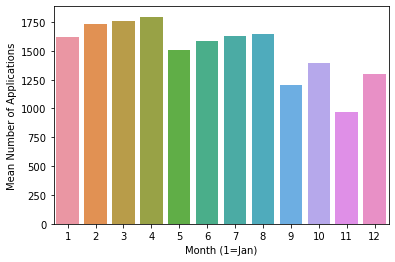

In [90]:
sns.barplot(x=plot_df['Month (1=Jan)'], y=plot_df['Mean Number of Applications'], data=plot_df)


We have just done EDA on the application_month field to determine which month is the most popular for loan applications.

# Step 13

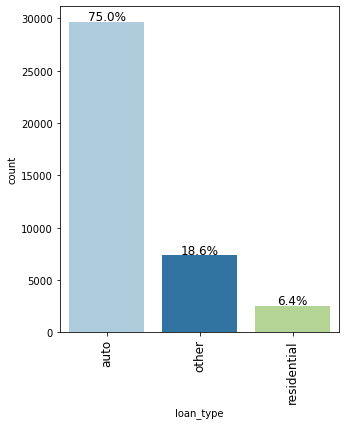

In [91]:
bargraph_with_labels(df, 'loan_type', perc=True)
plt.show()

Three quarters of loan customers are auto loan customers, while the smallest proportion, a bit over 5%, are residential loan customers.

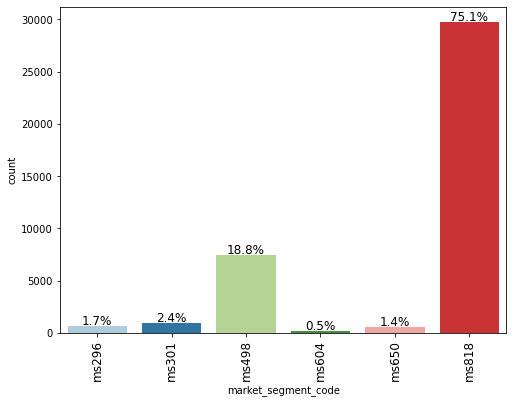

In [92]:
bargraph_with_labels(df, 'market_segment_code', perc=True)
plt.show()

The large majority of loan seekers come from the market segment ms818, while the fewest come from ms296, ms301, ms604, and ms650.

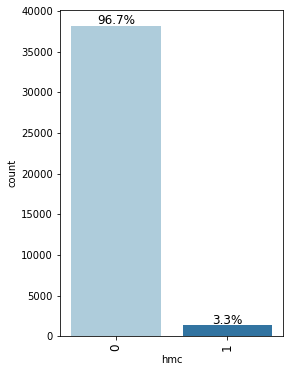

In [93]:
bargraph_with_labels(df, 'hmc', perc=True)
plt.show()

The vast majority of loans, almost 100%, are HMC, or hard money commerical loans, which are essentially non-bankable loans.

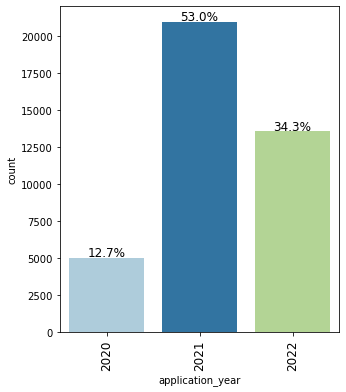

In [94]:
bargraph_with_labels(df, 'application_year', perc=True)
plt.show()

The fewest number of loan applications were made in 2020, likely due to the pandemic, while the most (almost half of the total number) were made in 2021.

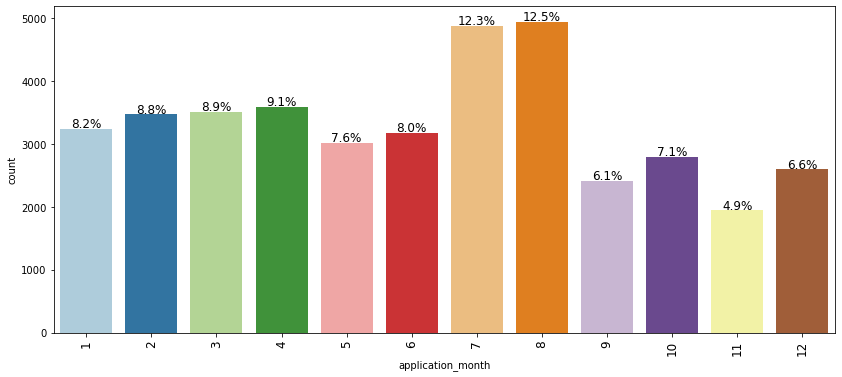

In [95]:
bargraph_with_labels(df, 'application_month', perc=True)
plt.show()

The largest proportion of loans were made in July and August, interestingly, just before the beginning of the academic year in the United States. The largest dip in number of loans occurs between August and September with a decrease from 12.5% to 6.1%.

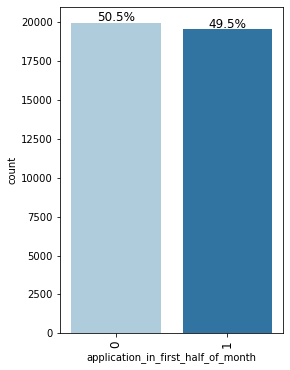

In [96]:
bargraph_with_labels(df, 'application_in_first_half_of_month', perc=True)
plt.show()

The number of loan applications in the first half of the month is almost exactly equal to the number of applicants in the second half of the month.

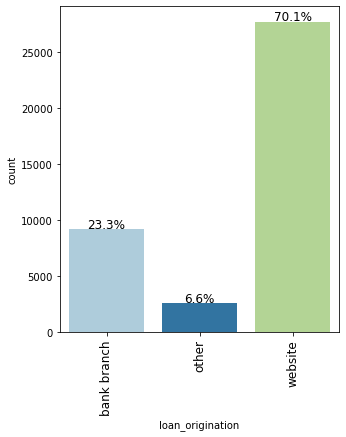

In [97]:
bargraph_with_labels(df, 'loan_origination', perc=True)
plt.show()

The large majority of customers originated their loans on the website, and a good amount-- albeit the smallest number, 6.6%-- chose a method "other" than online or in person at a bank branch.

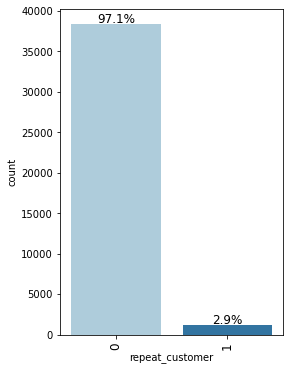

In [98]:
bargraph_with_labels(df, 'repeat_customer', perc=True)
plt.show()

A surprisingly low percentage of customers are repeat customers-- most do not return for another loan.

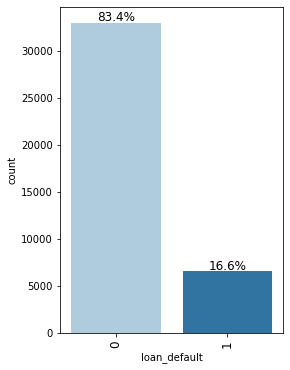

In [99]:
bargraph_with_labels(df, 'loan_default', perc=True)
plt.show()

As we explained in step 11, there is quite a bit of skewness in the target variable split, with there being about five times as many loan payoffs as defaults.

We have just completed an initial EDA of all our categorical variables, including the target variable.

# Step 14: Univariate EDA of each quantitative variable

loan_type                           39546 non-null  category
 1   loan_amount_index                   39546 non-null  int64   
 2   previous_defaults                   39546 non-null  int64   
 3   previous_nondefaults                39546 non-null  int64   
 4   previous_loan_count                 39546 non-null  int64   
 5   cars_in_household                   39546 non-null  int64   
 6   other_vehicles_owned                39546 non-null  int64   
 7   adults_in_household                 39546 non-null  int64   
 8   children_in_household               39546 non-null  int64   
 9   market_segment_code                 39546 non-null  category
 10  issues_needing_resolution           39546 non-null  int64   
 11  hmc                                 39546 non-null  int64   
 12  application_year                    39546 non-null  category
 13  application_month                   39546 non-null  category
 14  application_in_first_half_of_month  39546 non-null  int64   
 15  loan_origination                    39546 non-null  category
 16  repeat_customer                     39546 non-null  int64   
 17  mystery_field                       39546 non-null  int64   
 18  loan_default                        39546 non-null  int64   

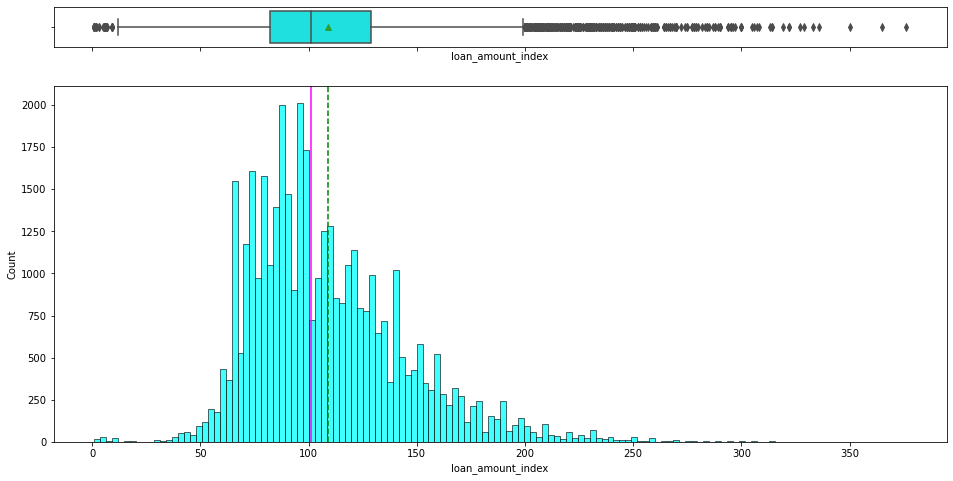

In [103]:
boxpl_and_hist(df['loan_amount_index'])

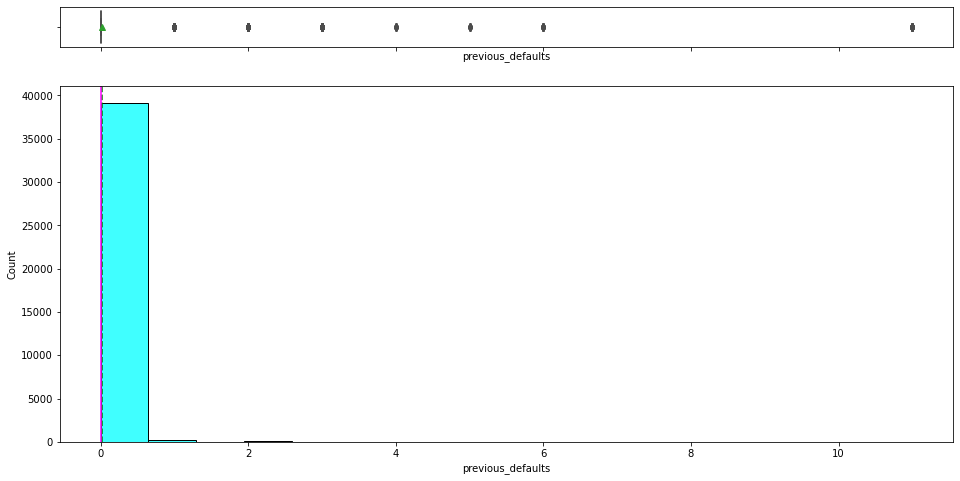

In [104]:
boxpl_and_hist(df['previous_defaults'])

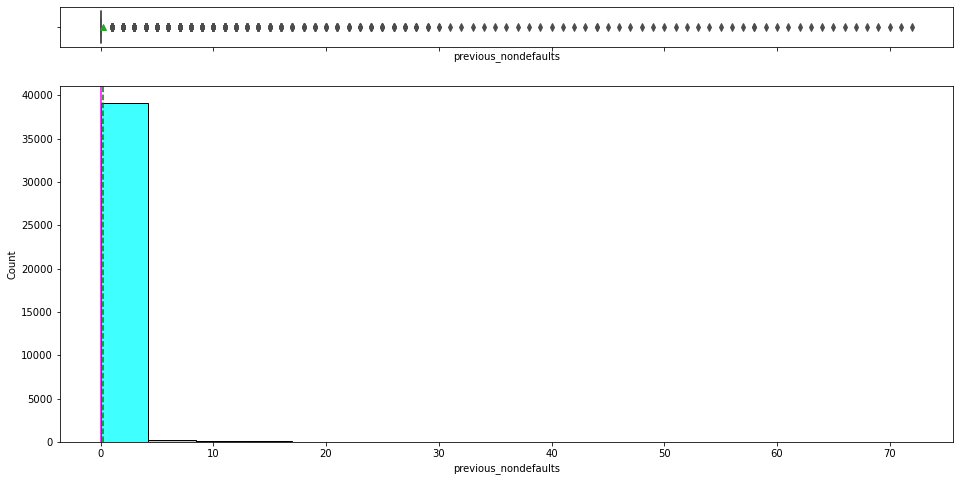

In [105]:
boxpl_and_hist(df['previous_nondefaults'])

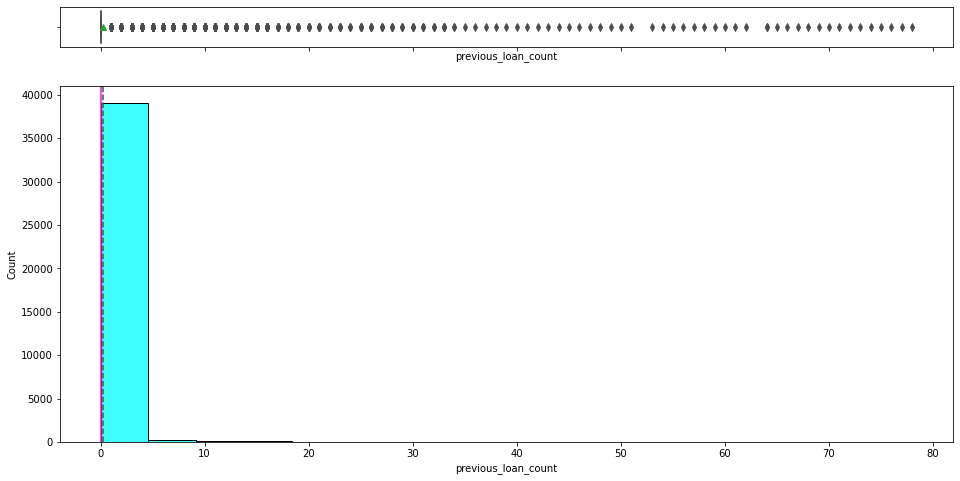

In [107]:
boxpl_and_hist(df['previous_loan_count'])

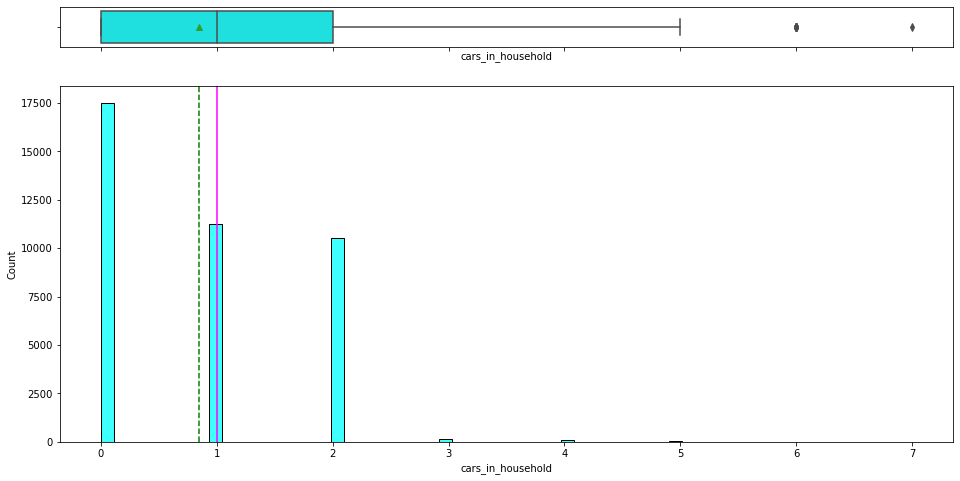

In [108]:
boxpl_and_hist(df['cars_in_household'])

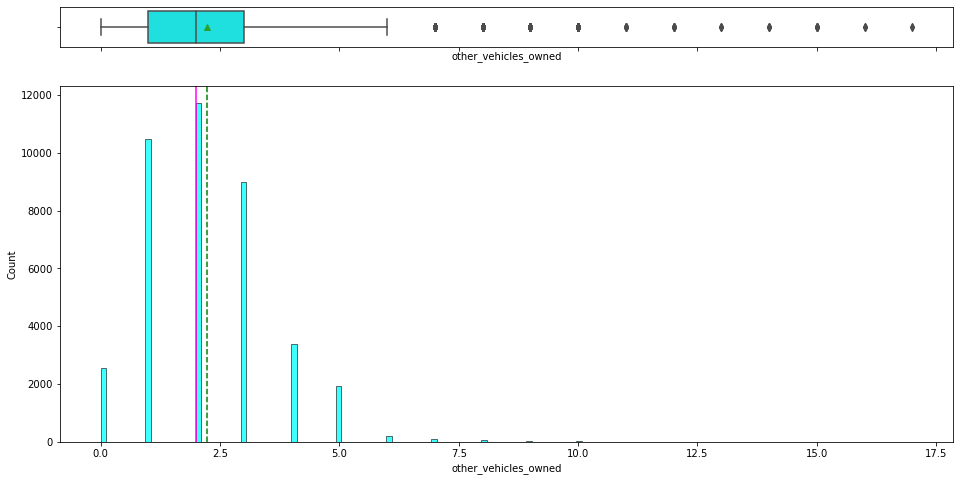

In [109]:
boxpl_and_hist(df['other_vehicles_owned'])